In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from random import randint
import cv2

In [2]:
def normalization1(image, mean, std):
    """ Normalization using mean and std
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """

    image = image / 255  # values will lie between 0 and 1.
    image = (image - mean) / std

    return image

def normalization2(image, max, min):
    """Normalization to range of [min, max]
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """
    image_new = (image-np.min(image))*(max-min)/(np.max(image)-np.min(image)) + min
    return image_new

def add_gaussian_noise(image, mean=0, std=1):
    """
    Args:
        image : numpy array of image
        mean : pixel mean of image
        standard deviation : pixel standard deviation of image
    Return :
        image : numpy array of image with gaussian noise added
    """
    gaus_noise = np.random.normal(mean, std, image.shape)
    image = image.astype("int16")
    noise_img = image + gaus_noise
    image = ceil_floor_image(image)
    return noise_img

def add_uniform_noise(image, low=-10, high=10):
    """
    Args:
        image : numpy array of image
        low : lower boundary of output interval
        high : upper boundary of output interval
    Return :
        image : numpy array of image with uniform noise added
    """
    uni_noise = np.random.uniform(low, high, image.shape)
    image = image.astype("int16")
    noise_img = image + uni_noise
    image = ceil_floor_image(image)
    return noise_img

def change_brightness(image, value):
    """
    Args:
        image : numpy array of image
        value : brightness
    Return :
        image : numpy array of image with brightness added
    """
    image = image.astype("int16")
    image = image + value
    image = ceil_floor_image(image)
    return image

def ceil_floor_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 with ceilling(maximum 255) and flooring(minimum 0)
    """
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype("uint8")
    return image

def cropping(image, crop_size, dim1, dim2):
    """crop the image and pad it to in_size
    Args :
        images : numpy array of images
        crop_size(int) : size of cropped image
        dim1(int) : vertical location of crop
        dim2(int) : horizontal location of crop
    Return :
        cropped_img: numpy array of cropped image
    """
    cropped_img = image[dim1:dim1+crop_size, dim2:dim2+crop_size]
    return cropped_img

In [3]:
def plot_two(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

In [4]:
from PIL import Image

b = Image.open("data/train/images/014.png")
c = Image.open("data/train/masks/014.png")

original = np.array(b)
originall = np.array(c)
original_norm = normalization2(original, max=1, min=0)
# print(np.all(original==original_norm))
# plot_two(original, original_norm)

In [25]:
def add_elastic_transform(image, alpha, sigma, alpha_affine=30, pad_size=0, seed=None):
    """
    Args:
        image : numpy array of image
        alpha : α is a scaling factor, shift distance
        sigma : σ is an elasticity coefficient, gausian kernel std
        random_state = random integer
    Return :
        image : elastically transformed numpy array of image
    """
    if seed is None:
        seed = randint(1, 100)
        random_state = np.random.RandomState(seed)
    else:
        random_state = np.random.RandomState(seed)
        
#     shape = image.shape
#     shape_size = shape[:2]
        
#     # Random affine
#     center_square = np.float32(shape_size) // 2
#     square_size = min(shape_size) // 3
#     pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
#     pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
#     M = cv2.getAffineTransform(pts1, pts2)
#     image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
        
    image = np.pad(image, pad_size, mode="symmetric")
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),  # [-1, 1] uniform distribution
                         sigma, mode="constant", cval=0) * alpha
    print(np.unique(dx))
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))  # simulate coordinates
    coordinates = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    new_image = map_coordinates(image, coordinates, order=1).reshape(shape)
    return cropping(new_image, 512, pad_size, pad_size), seed

(array([ 3., 22., 37., 76., 92., 97., 71., 57., 43., 14.]),
 array([-0.84246476, -0.68824266, -0.53402056, -0.37979846, -0.22557636,
        -0.07135425,  0.08286785,  0.23708995,  0.39131205,  0.54553415,
         0.69975626]),
 <a list of 10 Patch objects>)

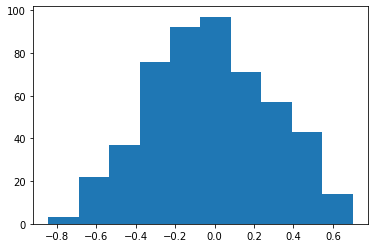

In [75]:
seed = 50
sigma = 1
alpha = 1
a = np.random.RandomState(seed).rand(512) * 2 - 1
dx = gaussian_filter((a), sigma, mode="constant", cval=0) * alpha

plt.hist(dx)

[-4.45834943 -4.45820361 -4.45810029 ...  3.18500168  3.18502917
  3.18521475]
[-2.62846337 -2.62833252 -2.62420904 ...  2.88617328  2.89101447
  2.90783692]
CPU times: user 648 ms, sys: 12 ms, total: 660 ms
Wall time: 1.05 s


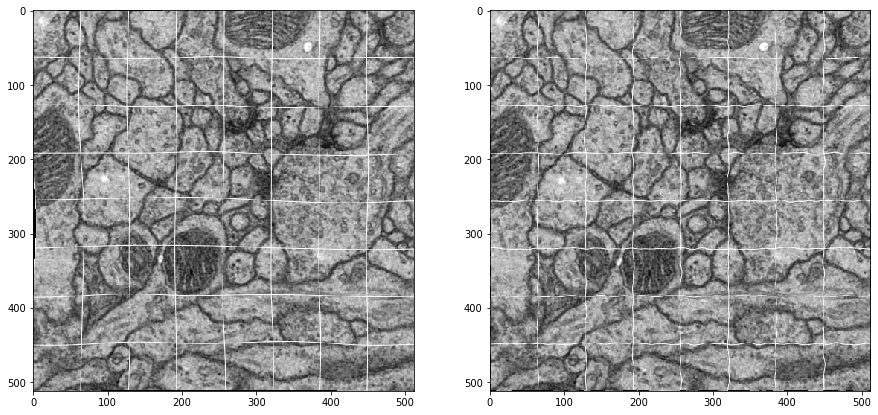

In [82]:
%%time
draw_grid(original, 64)
original1, seed = add_elastic_transform(original, 500, 50)
original2, seed = add_elastic_transform(original, 20, 5)

plot_two(original1, original2)
# plt.figure(figsize = (14,7))
# plt.imshow(np.c_[original, original1], cmap='gray')

In [ ]:
original_pad = np.pad(original, 256, mode='symmetric')
plot_two(original, original_pad)

In [ ]:
original1 = add_gaussian_noise(original, 0, 50)
plot_two(original, original1)

In [ ]:
original1 = add_uniform_noise(original, -100, 100)
plot_two(original, original1)

In [ ]:
original1 = change_brightness(original, 20)
plot_two(original, original1)